In [1]:
import os
import collections
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

# Suppressing tf.hub warnings
tf.get_logger().setLevel("ERROR")

In [2]:
#besst 11
batch_size = 32
print("Loading vision and text encoders...")
vision_encoder = keras.models.load_model("vision_encoder_11")
text_encoder = keras.models.load_model("text_encoder_11")
print("Models are loaded.")

Loading vision and text encoders...


2022-09-04 22:46:20.024483: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-04 22:46:20.058350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-04 22:46:20.058749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-04 22:46:20.060065: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Models are loaded.


In [3]:
root_dir = "datasets_incidents"
annotations_dir = os.path.join(root_dir, "annotations")
images_dir = os.path.join(root_dir, "incidents_cleaned")
tfrecords_dir = os.path.join(root_dir, "tfrecords")
annotation_file = os.path.join(annotations_dir, "capLabel_All.json")
print(annotation_file)
with open(annotation_file, "r") as f:
    annotations = json.load(f)

image_path_to_caption = collections.defaultdict(list)
for element in annotations:
    caption = f"{element['caption'].lower().rstrip('.')}"
    image_path = images_dir + '/' + element["image_id"]
    image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
print(f"Number of images: {len(image_paths)}")

datasets_incidents/annotations/capLabel_All.json
Number of images: 11564


In [4]:
def read_image(image_path):
    image_array = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
    return tf.image.resize(image_array, (299, 299))
    
print(f"Generating embeddings for {len(image_paths)} images...")
image_embeddings = vision_encoder.predict(
    tf.data.Dataset.from_tensor_slices(image_paths).map(read_image).batch(batch_size),
    verbose=1,
)
print(f"Image embeddings shape: {image_embeddings.shape}.")

Generating embeddings for 11564 images...


2022-09-04 22:47:07.165006: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204
2022-09-04 22:47:08.075191: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-09-04 22:47:08.076606: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-09-04 22:47:08.076620: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-09-04 22:47:08.076673: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

  1/362 [..............................] - ETA: 23:34

2022-09-04 22:47:09.623512: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


362/362 [==============================] - 55s 141ms/step
Image embeddings shape: (11564, 256).


In [6]:
def find_matches(image_embeddings, queries, k=200, normalize=True):
    # Get the embedding for the query.
    query_embedding = text_encoder(tf.convert_to_tensor(queries))
    # Normalize the query and the image embeddings.
    if normalize:
        image_embeddings = tf.math.l2_normalize(image_embeddings, axis=1)
        query_embedding = tf.math.l2_normalize(query_embedding, axis=1)
    # Compute the dot product between the query and the image embeddings.
    dot_similarity = tf.matmul(query_embedding, image_embeddings, transpose_b=True)
    print(dot_similarity.shape)
    # Retrieve top k indices.
    results = tf.math.top_k(dot_similarity, k).indices.numpy()
    # Return matching image paths.
    return [[image_paths[idx] for idx in indices] for indices in results]

In [26]:
query = "a herd of sheep"
query_embedding = text_encoder(tf.convert_to_tensor([query]))
query_embedding.shape

TensorShape([1, 256])

(1, 11564)


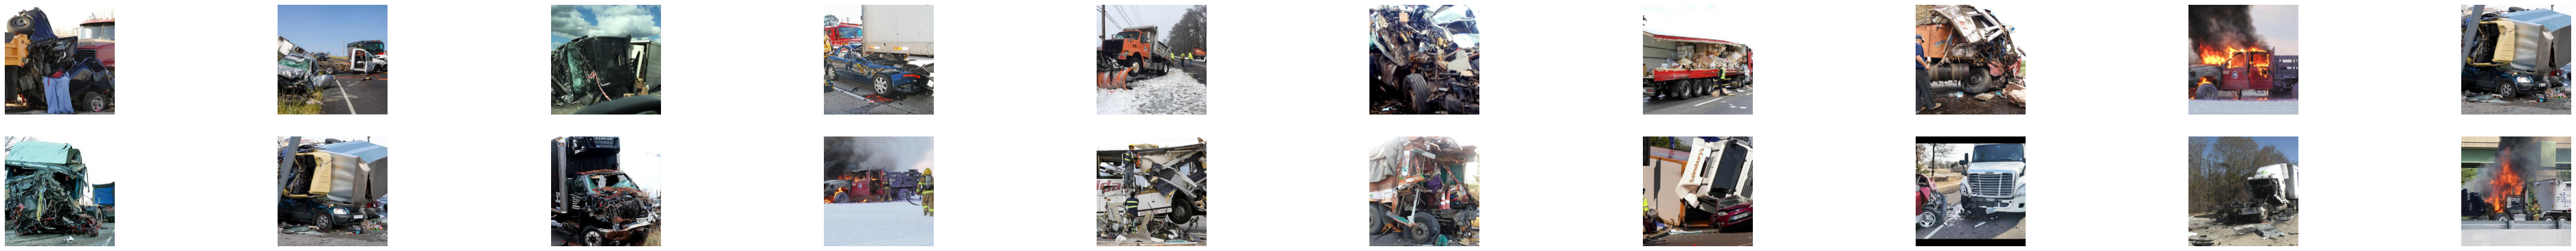

In [23]:
query = "a dump truck that is sitting on the ground"
matches = find_matches(image_embeddings, [query], normalize=True)[0]
#matches
plt.figure(figsize=(70, 70))
for i in range(20):
    ax = plt.subplot(20, 10, i + 1)
    plt.imshow(mpimg.imread(matches[i]))
    plt.axis("off")

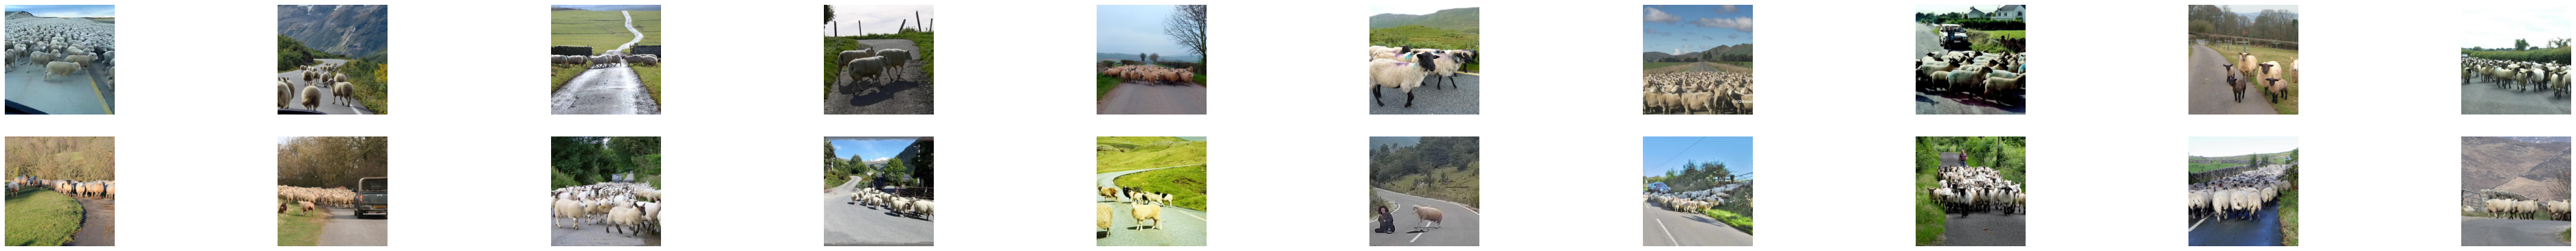

In [45]:
plt.figure(figsize=(70, 70))
for i in range(20):
    ax = plt.subplot(20, 10, i + 1)
    plt.imshow(mpimg.imread(matches[i]))
    plt.axis("off")

In [37]:
import flask
import json
from flask import Flask, flash, request, redirect, url_for, render_template, jsonify
from flask_cors import CORS
import pandas as pd
import numpy as np
import time
from sklearn.metrics.pairwise import cosine_similarity
import os

In [38]:
app = Flask(__name__)
cors = CORS(app, resources={r"/*": {"origins": "*"}})

In [40]:
@app.route("/<filename>")
def display_media(filename):
    print(filename)
    file_details = os.path.splitext(filename)
    file_name = file_details[0]
    file_extension = file_details[1]

    print("File Name: ", file_name)
    print("File Extension: ", file_extension)
    return redirect(url_for('static', filename= 'dataset/' + filename), code=301)
    
@app.route('/STS/<user_input>', methods = ['GET'])
def STS_filename_from_embed(user_input):
    query = user_input
    matches = find_matches(image_embeddings, [query], normalize=True)[0]
    matches = [mat.replace("datasets_incidents/incidents_cleaned/", "") for mat in matches]
    
    return jsonify(
        Data = matches
        # Status = 200, 
        # Msg = 'OK'
        ) 

In [42]:
if __name__ == "__main__":
    app.run(host="192.168.0.164", port=8009)

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://192.168.0.164:8009/ (Press CTRL+C to quit)
192.168.0.164 - - [19/Aug/2022 00:05:08] "GET /STS/a%20herd%20of%20sheep%20standing%20on%20top%20of%20a%20road HTTP/1.1" 200 -
192.168.0.164 - - [19/Aug/2022 00:05:08] "GET /favicon.ico HTTP/1.1" 301 -
192.168.0.164 - - [19/Aug/2022 00:05:08] "GET /static/dataset/favicon.ico HTTP/1.1" 404 -


(1, 11564)
favicon.ico
File Name:  favicon
File Extension:  .ico


192.168.0.164 - - [19/Aug/2022 00:05:20] "GET /static/dataset/2753051_7207cefe_original.jpg HTTP/1.1" 200 -
192.168.0.174 - - [19/Aug/2022 00:05:35] "GET /STS/a%20herd%20of%20sheep%20standing%20on%20top%20of%20a%20road HTTP/1.1" 200 -
192.168.0.174 - - [19/Aug/2022 00:05:35] "GET /favicon.ico HTTP/1.1" 301 -
192.168.0.174 - - [19/Aug/2022 00:05:35] "GET /static/dataset/favicon.ico HTTP/1.1" 404 -


(1, 11564)
favicon.ico
File Name:  favicon
File Extension:  .ico


192.168.0.174 - - [19/Aug/2022 00:07:13] "OPTIONS //STS/a%20herd%20of%20sheep%20standing%20on%20top%20of%20a%20road HTTP/1.1" 200 -
192.168.0.174 - - [19/Aug/2022 00:07:13] "GET //STS/a%20herd%20of%20sheep%20standing%20on%20top%20of%20a%20road HTTP/1.1" 200 -
192.168.0.174 - - [19/Aug/2022 00:07:13] "GET /static/dataset/2753051_7207cefe_original.jpg HTTP/1.1" 200 -
192.168.0.174 - - [19/Aug/2022 00:07:13] "GET /static/dataset/1BFCC4B55C0C7D4FE6BAFE2C940274B905D51C58.jpg HTTP/1.1" 200 -
192.168.0.174 - - [19/Aug/2022 00:07:13] "GET /static/dataset/4834066_a3e48891.jpg HTTP/1.1" 200 -
192.168.0.174 - - [19/Aug/2022 00:07:13] "GET /static/dataset/5116891_0ce13368.jpg HTTP/1.1" 200 -
192.168.0.174 - - [19/Aug/2022 00:07:13] "GET /static/dataset/2BC916F750A8E555437E3656357D8071527A390F.jpg HTTP/1.1" 200 -
192.168.0.174 - - [19/Aug/2022 00:07:13] "GET /static/dataset/6290730535.jpg HTTP/1.1" 200 -
192.168.0.174 - - [19/Aug/2022 00:07:13] "GET /static/dataset/XWtn1hpD9J.jpg HTTP/1.1" 200 -
19

(1, 11564)


192.168.0.174 - - [19/Aug/2022 00:07:13] "GET /static/dataset/2597554_a4cc7d7b_original.jpg HTTP/1.1" 200 -
192.168.0.174 - - [19/Aug/2022 00:07:13] "GET /static/dataset/EOSGas2cUk.jpg HTTP/1.1" 200 -
192.168.0.174 - - [19/Aug/2022 00:07:13] "GET /static/dataset/38518844090.jpg HTTP/1.1" 200 -
192.168.0.174 - - [19/Aug/2022 00:07:13] "GET /static/dataset/8AAF2179E8C67717280F4FBC5D44735D13909437.jpg HTTP/1.1" 200 -
192.168.0.174 - - [19/Aug/2022 00:07:13] "GET /static/dataset/3904480_ab7fcbaa.jpg HTTP/1.1" 200 -
192.168.0.174 - - [19/Aug/2022 00:07:13] "GET /static/dataset/B816FCAC85590372490E6362B213333199AA1796.jpg HTTP/1.1" 200 -
192.168.0.174 - - [19/Aug/2022 00:07:13] "GET /static/dataset/D9XZbbDjn5.jpg HTTP/1.1" 200 -
192.168.0.174 - - [19/Aug/2022 00:07:13] "GET /static/dataset/A3CE10C9A06240A0B44448A0459A53A982EACF86.jpg HTTP/1.1" 200 -
192.168.0.174 - - [19/Aug/2022 00:07:13] "GET /static/dataset/24004771898.jpg HTTP/1.1" 200 -
192.168.0.174 - - [19/Aug/2022 00:07:13] "GET /sta